In [1]:
import torch
import os
import tqdm

import sys
sys.path.append("../../..")
from utils.checkpoint import save_ckpt_template as save_ckpt, load_ckpt_template as load_ckpt

if torch.cuda.is_available():
    device = torch.device('cuda')
    torch.backends.cudnn.benchmark = True   # 加速卷积计算
else:
    device = torch.device('cpu')

print(device)

cuda


In [2]:
device = "cuda:1"

In [ ]:
from data.septimbre.data import Instruments
dataset = Instruments(
    folder = '../../../data/septimbre/multi_large_256',
    mix = 1,
    input = '.wav',
    output = '.npy'
)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=18, shuffle=True, pin_memory=True, num_workers=4)
print("训练集大小: ", len(dataset))
input, label = dataset[0]
print("输入大小: ", input.shape)
print("输出大小: ", label.shape)

val = Instruments(
    folder = '../../../data/septimbre/multi_medium_256',
    mix = 1,
    input = '.wav',
    output = '.npy'
)
valloader = torch.utils.data.DataLoader(val, batch_size=18, shuffle=False, pin_memory=True, num_workers=4)
print("测试集大小: ", len(val))
input, label = val[0]
print("输入大小: ", input.shape)
print("输出大小: ", label.shape)

# CQT配置
from model.config import CONFIG
s_per_frame = CONFIG.s_per_frame

_model = None

训练集大小:  8316
输入大小:  torch.Size([1, 1, 230400])
输出大小:  torch.Size([1, 84, 900])
测试集大小:  720
输入大小:  torch.Size([1, 1, 230400])
输出大小:  torch.Size([1, 84, 900])


In [4]:
# 从分体开始
from basicamt_noDilation import BasicAMT_noDilation, BasicAMT_all_noDilation
_model = BasicAMT_noDilation().to(device)
optimizer = torch.optim.AdamW(_model.parameters(), lr=2e-4)
checkpoint_path = "basicamt_noDilation.pth"

# 加载最佳模型
states = load_ckpt(_model, optimizer, "best_" + checkpoint_path)
if not states:
    print("No best checkpoint loaded.")

Checkpoint loaded from 'best_basicamt_noDilation.pth'
epoch: 4, loss: 9999.727194335937, min_loss: 13394.437654785155


In [ ]:
from basicamt_noDilation import BasicAMT_noDilation, BasicAMT_all_noDilation
if _model is not None:
    model = BasicAMT_all_noDilation(CONFIG.CQT, _model.state_dict(), CQTlearnable=False).to(device)
    print("model initialized from BasicAMT")
else:
    model = BasicAMT_all_noDilation(CONFIG.CQT, CQTlearnable=False).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-4)
schedular = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.3, patience=2, threshold=1e-3)
checkpoint_path = "basicamt_all_noDilation.pth"
loss_path = "basicamt_all_noDilation.loss.txt"
min_loss = float('inf')
epoch_now = 0

model initialized from BasicAMT


In [6]:
# 加载上一轮模型参数
states = load_ckpt(model, optimizer, checkpoint_path)
if states:
    min_loss, avg_loss, epoch_now = states
else:
    print("No checkpoint loaded. Training from scratch.")

Checkpoint file 'basicamt_all_noDilation.pth' does not exist.
No checkpoint loaded. Training from scratch.


In [7]:
model = torch.compile(model)

In [8]:
epoch_total = 50
stage_save_interval = 40    # save checkpoint every $stage_save_interval$ epochs

optimizer.zero_grad()
for epoch in range(epoch_now+1, epoch_total):
    # training
    model.train()
    train_loss = 0
    virtual_batch = 0
    for (input, target) in tqdm.tqdm(dataloader):
        input = input.to(device)    # input: (batch, mix, 2, time)
        target = target.to(device)  # target: (batch, mix, 7 * 12, 660)

        # 由于basicamt的目标没有分离音色，因此mix仅仅是数据增强的手段
        if dataset.mix > 1:
            mixed = torch.mean(input, dim=1, keepdim=False)  # 混合后的CQT
            midi_mixed, _ = target.max(dim=-3, keepdim=False)
        else:
            mixed = input.squeeze(dim=1)
            midi_mixed = target.squeeze(dim=1)

        mixed = mixed + torch.randn_like(mixed) * 0.005   # 加入噪声 经过听觉和可视化觉得0.005是一个合适的值
        # midi_mixed: (batch, 7 * 12, 660)

        onset, note = model(mixed)
        # onset & note: (batch, 7 * 12, 660)
        loss = BasicAMT_noDilation.loss(onset, note, midi_mixed)
        train_loss += loss.item()

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        model.clampK()

    train_loss /= len(dataloader)

    # validation
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for (input, target) in tqdm.tqdm(valloader):
            input = input.to(device)
            target = target.to(device)

            if val.mix > 1:
                mixed = torch.sum(input, dim=1, keepdim=False)
                midi_mixed, _ = target.max(dim=-3, keepdim=False)
            else:
                mixed = input.squeeze(dim=1)
                midi_mixed = target.squeeze(dim=1)

            onset, note = model(mixed)
            loss = BasicAMT_noDilation.loss(onset, note, midi_mixed)
            val_loss += loss.item()

        val_loss /= len(valloader)
    
    final_loss = val_loss * 0.85 + train_loss * 0.15
    schedular.step(final_loss)

    # save checkpoint
    checkpoint_filename = f"epoch{epoch}.pth" if epoch % stage_save_interval == 0 else checkpoint_path
    save_ckpt(epoch, model, min_loss, final_loss, optimizer, checkpoint_filename)
    if final_loss < min_loss:
        min_loss = final_loss

    print(f"====> Epoch: {epoch} Average train loss: {train_loss:.4f}; Average val loss: {val_loss:.4f}")
    with open(loss_path, 'a') as f:
        f.write(f"{epoch}:\ttrain_loss: {train_loss:.4f}\tval_loss: {val_loss:.4f}\n")
    epoch_now = epoch

100%|██████████| 40/40 [00:04<00:00,  9.23it/s]


====> Epoch: 1 Average train loss: 10057.8133; Average val loss: 7300.8478


100%|██████████| 40/40 [00:01<00:00, 22.81it/s]


====> Epoch: 2 Average train loss: 6686.4942; Average val loss: 6268.8147


100%|██████████| 40/40 [00:01<00:00, 22.96it/s]


====> Epoch: 3 Average train loss: 6114.2243; Average val loss: 6019.5536


100%|██████████| 40/40 [00:01<00:00, 22.77it/s]


====> Epoch: 4 Average train loss: 5790.7616; Average val loss: 5861.2965


100%|██████████| 40/40 [00:01<00:00, 22.84it/s]


====> Epoch: 5 Average train loss: 5569.9534; Average val loss: 5533.4162


100%|██████████| 40/40 [00:01<00:00, 22.68it/s]


====> Epoch: 6 Average train loss: 5421.7433; Average val loss: 5443.7118


100%|██████████| 40/40 [00:01<00:00, 23.42it/s]


====> Epoch: 7 Average train loss: 5304.5537; Average val loss: 5335.4555


100%|██████████| 40/40 [00:01<00:00, 23.10it/s]


====> Epoch: 8 Average train loss: 5195.2400; Average val loss: 5211.3380


100%|██████████| 40/40 [00:01<00:00, 23.29it/s]


====> Epoch: 9 Average train loss: 5117.9458; Average val loss: 5178.7674


100%|██████████| 40/40 [00:01<00:00, 23.35it/s]


====> Epoch: 10 Average train loss: 5042.7741; Average val loss: 5052.0987


100%|██████████| 40/40 [00:01<00:00, 23.22it/s]


====> Epoch: 11 Average train loss: 4987.6464; Average val loss: 4965.4281


100%|██████████| 40/40 [00:01<00:00, 23.21it/s]


====> Epoch: 12 Average train loss: 4942.8555; Average val loss: 5184.6600


100%|██████████| 40/40 [00:01<00:00, 23.26it/s]


====> Epoch: 13 Average train loss: 4888.4032; Average val loss: 4896.9955


100%|██████████| 40/40 [00:01<00:00, 23.02it/s]


====> Epoch: 14 Average train loss: 4844.0871; Average val loss: 4912.7126


100%|██████████| 40/40 [00:01<00:00, 23.04it/s]


====> Epoch: 15 Average train loss: 4813.9547; Average val loss: 4826.0115


100%|██████████| 40/40 [00:01<00:00, 23.13it/s]


====> Epoch: 16 Average train loss: 4787.3659; Average val loss: 5157.0661


100%|██████████| 40/40 [00:01<00:00, 23.15it/s]


====> Epoch: 17 Average train loss: 4748.9168; Average val loss: 4848.2761


100%|██████████| 40/40 [00:01<00:00, 23.18it/s]


====> Epoch: 18 Average train loss: 4722.5304; Average val loss: 4924.0082


100%|██████████| 40/40 [00:01<00:00, 23.00it/s]


====> Epoch: 19 Average train loss: 4633.1397; Average val loss: 4810.2908


100%|██████████| 40/40 [00:01<00:00, 22.93it/s]


====> Epoch: 20 Average train loss: 4623.2121; Average val loss: 4725.7084


100%|██████████| 40/40 [00:01<00:00, 23.09it/s]


====> Epoch: 21 Average train loss: 4621.4201; Average val loss: 4696.3305


100%|██████████| 40/40 [00:01<00:00, 23.21it/s]


====> Epoch: 22 Average train loss: 4606.5725; Average val loss: 4744.8973


100%|██████████| 40/40 [00:01<00:00, 23.25it/s]


====> Epoch: 23 Average train loss: 4599.9772; Average val loss: 4691.7895


100%|██████████| 40/40 [00:01<00:00, 23.05it/s]


====> Epoch: 24 Average train loss: 4590.1435; Average val loss: 4780.9950


100%|██████████| 40/40 [00:01<00:00, 22.90it/s]


====> Epoch: 25 Average train loss: 4582.9822; Average val loss: 4810.7752


100%|██████████| 40/40 [00:01<00:00, 23.10it/s]


====> Epoch: 26 Average train loss: 4575.9013; Average val loss: 4673.3088


100%|██████████| 40/40 [00:01<00:00, 23.15it/s]


====> Epoch: 27 Average train loss: 4568.6131; Average val loss: 4690.1712


100%|██████████| 40/40 [00:01<00:00, 23.25it/s]


====> Epoch: 28 Average train loss: 4555.9684; Average val loss: 4673.7258


100%|██████████| 40/40 [00:01<00:00, 23.06it/s]


====> Epoch: 29 Average train loss: 4549.1649; Average val loss: 4782.8298


100%|██████████| 40/40 [00:01<00:00, 23.00it/s]


====> Epoch: 30 Average train loss: 4524.6363; Average val loss: 4663.8378


100%|██████████| 40/40 [00:01<00:00, 23.18it/s]


====> Epoch: 31 Average train loss: 4519.7997; Average val loss: 4631.5831


100%|██████████| 40/40 [00:01<00:00, 22.94it/s]


====> Epoch: 32 Average train loss: 4517.2681; Average val loss: 4642.5201


100%|██████████| 40/40 [00:01<00:00, 22.72it/s]


====> Epoch: 33 Average train loss: 4517.9001; Average val loss: 4623.4313


100%|██████████| 40/40 [00:01<00:00, 23.21it/s]


====> Epoch: 34 Average train loss: 4514.3863; Average val loss: 4650.5003


100%|██████████| 40/40 [00:01<00:00, 23.05it/s]


====> Epoch: 35 Average train loss: 4509.7069; Average val loss: 4626.0727


100%|██████████| 40/40 [00:01<00:00, 23.03it/s]


====> Epoch: 36 Average train loss: 4507.9568; Average val loss: 4630.2744


100%|██████████| 40/40 [00:01<00:00, 23.15it/s]


====> Epoch: 37 Average train loss: 4497.3766; Average val loss: 4639.1599


100%|██████████| 40/40 [00:01<00:00, 22.91it/s]


====> Epoch: 38 Average train loss: 4495.7723; Average val loss: 4629.6009


100%|██████████| 40/40 [00:01<00:00, 22.90it/s]


====> Epoch: 39 Average train loss: 4497.6565; Average val loss: 4633.1850


100%|██████████| 40/40 [00:01<00:00, 23.16it/s]


====> Epoch: 40 Average train loss: 4493.8233; Average val loss: 4620.0158


100%|██████████| 40/40 [00:01<00:00, 23.01it/s]


====> Epoch: 41 Average train loss: 4496.2502; Average val loss: 4621.5829


100%|██████████| 40/40 [00:01<00:00, 23.26it/s]


====> Epoch: 42 Average train loss: 4492.6713; Average val loss: 4625.5800


100%|██████████| 40/40 [00:01<00:00, 23.26it/s]


====> Epoch: 43 Average train loss: 4494.2533; Average val loss: 4624.4507


100%|██████████| 40/40 [00:01<00:00, 23.08it/s]


====> Epoch: 44 Average train loss: 4492.5679; Average val loss: 4615.7886


100%|██████████| 40/40 [00:01<00:00, 23.11it/s]


====> Epoch: 45 Average train loss: 4491.2675; Average val loss: 4619.8553


100%|██████████| 40/40 [00:01<00:00, 22.83it/s]


====> Epoch: 46 Average train loss: 4494.1054; Average val loss: 4627.5659


100%|██████████| 40/40 [00:01<00:00, 23.16it/s]


====> Epoch: 47 Average train loss: 4491.5915; Average val loss: 4626.9051


100%|██████████| 40/40 [00:01<00:00, 23.01it/s]


====> Epoch: 48 Average train loss: 4490.6345; Average val loss: 4620.0752


100%|██████████| 40/40 [00:01<00:00, 22.93it/s]

====> Epoch: 49 Average train loss: 4490.6497; Average val loss: 4630.6238


In [9]:
model.cqt.cqt_kernels.requires_grad

False

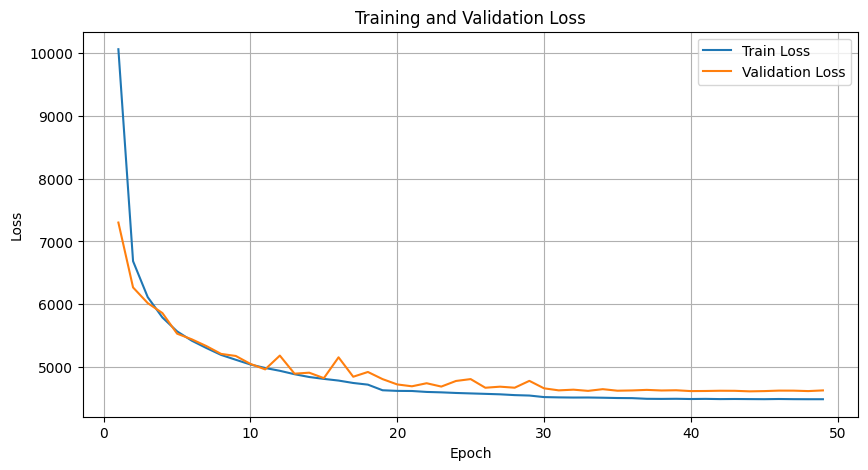

In [10]:
# 绘制训练和验证损失曲线
import matplotlib.pyplot as plt

epochs = []
train_losses = []
val_losses = []

with open(loss_path, 'r') as f:
    for line in f:
        parts = line.strip().split('\t')
        epoch = int(parts[0].split(':')[0])
        train_loss = float(parts[1].split(': ')[1])
        val_loss = float(parts[2].split(': ')[1])
        
        epochs.append(epoch)
        train_losses.append(train_loss)
        val_losses.append(val_loss)

# Plot the losses
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

## 测试模型

In [11]:
# 加载最佳模型
states = load_ckpt(model, optimizer, "best_" + checkpoint_path)
if states:
    min_loss, avg_loss, epoch_now = states
else:
    print("No best checkpoint loaded.")

Checkpoint loaded from 'best_basicamt_all_noDilation.pth'
epoch: 44, loss: 4597.305498609666, min_loss: 4601.086886412386


In [12]:
# 切换到cpu 因为benchmark会导致初次运行时间长
device = torch.device('cpu')
model = model.to(device)
torch.backends.cudnn.benchmark = False

Sample rate: 22050
Channels: 2
Sample width: 2
Number of frames: 2902528
Duration (s): 131.63392290249433
data num: 5805056
torch.Size([1, 2, 2902528])


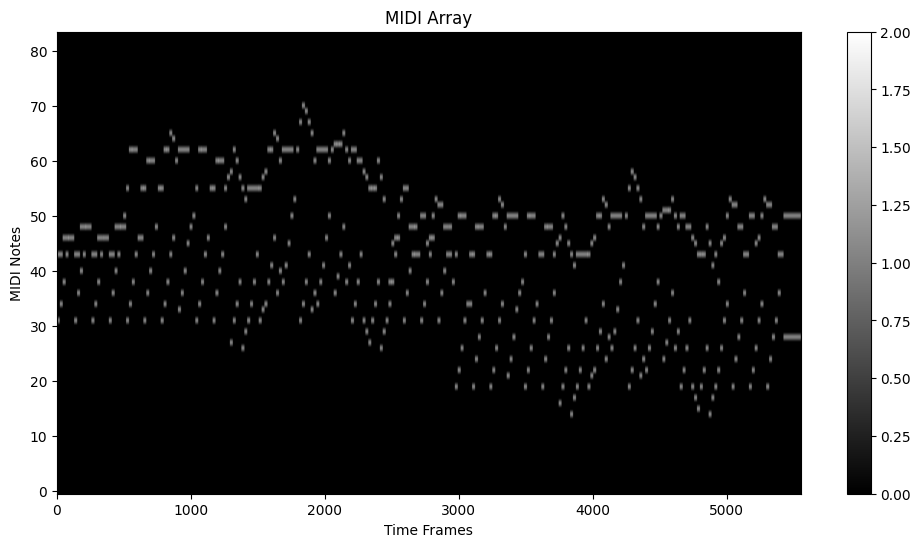

(84, 5556)


In [13]:
# 读取音频
import torchaudio
from utils.midiarray import midi2numpy
from utils.wavtool import waveInfo
import matplotlib.pyplot as plt
import numpy as np

# test_wave_path = "../../../data/inferMusic/piano_short.wav"
test_wave_path = "../../../data/inferMusic/孤独な巡礼simple.wav"
waveInfo(test_wave_path)

waveform, sample_rate = torchaudio.load(test_wave_path, normalize=True)
waveform = waveform.unsqueeze(0)
print(waveform.shape)

test_midi_path = test_wave_path.replace('.wav', '.mid')
s_per_frame = 256 / 22050
midi_array = midi2numpy(test_midi_path, s_per_frame)
plt.figure(figsize=(12, 6))
plt.imshow(midi_array, aspect='auto', origin='lower', cmap='gray')
plt.colorbar()
plt.title('MIDI Array')
plt.xlabel('Time Frames')
plt.ylabel('MIDI Notes')
plt.show()
print(midi_array.shape)

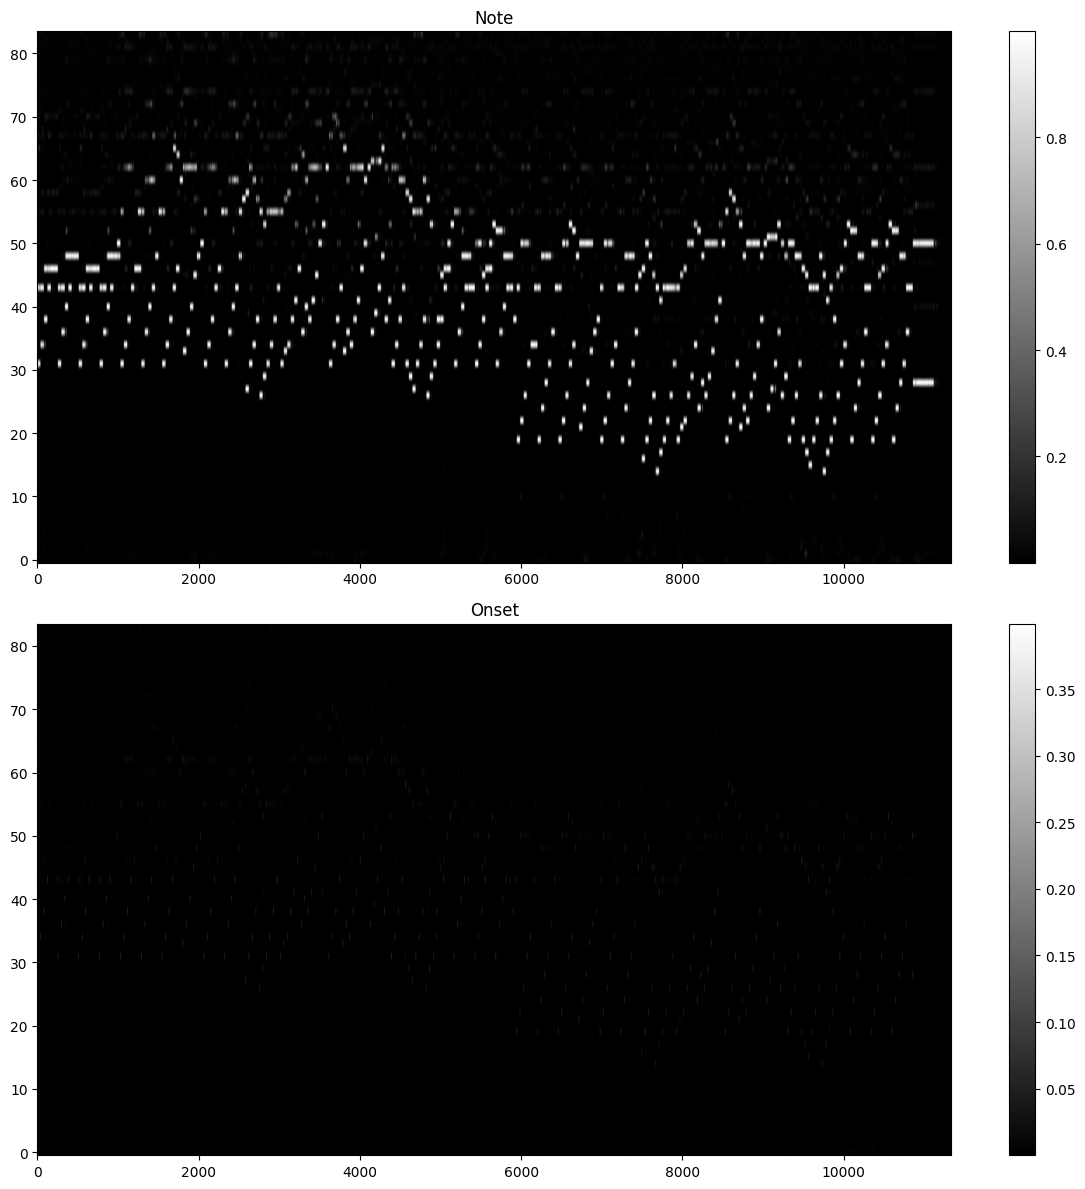

In [14]:
model.eval()
with torch.no_grad():
    onset, note = model(waveform)
    onset = onset.cpu().numpy()[0]
    note = note.cpu().numpy()[0]
    plt.figure(figsize=(12, 12))

    plt.subplot(2, 1, 1)
    plt.title('Note')
    plt.imshow(note, aspect='auto', origin='lower', cmap='gray')
    plt.colorbar()

    plt.subplot(2, 1, 2)
    plt.title('Onset')
    plt.imshow(onset, aspect='auto', origin='lower', cmap='gray')
    plt.colorbar()

    plt.tight_layout()
    plt.show()

In [15]:
# final model to be used by others
torch.save(model, "basicamt_model_noDilation.pth")